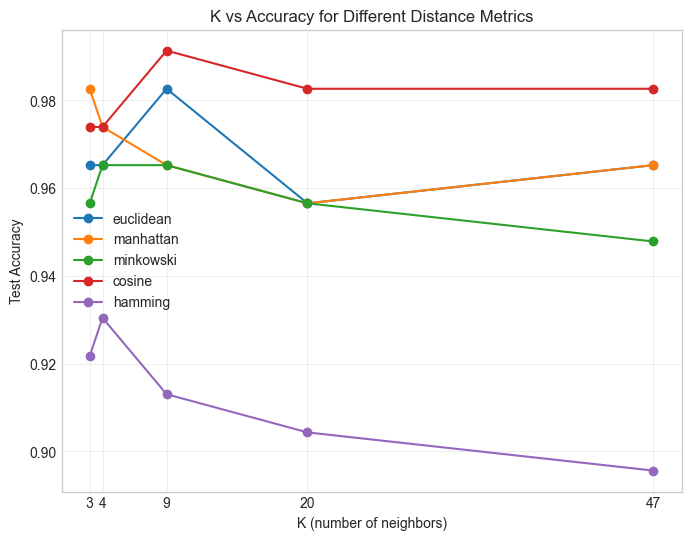

Best metric: cosine, Best K: 9, Test Accuracy: 0.991304

Confusion Matrix (rows: actual [0,1], cols: predicted [0,1]):
[[72  0]
 [ 1 42]]

Precision (for class=1/malignant): 1.000000
Recall    (for class=1/malignant): 0.976744

All results (metric, k) -> accuracy:
euclidean   k= 3  acc=0.965217
euclidean   k= 4  acc=0.965217
euclidean   k= 9  acc=0.982609
euclidean   k=20  acc=0.956522
euclidean   k=47  acc=0.965217
manhattan   k= 3  acc=0.982609
manhattan   k= 4  acc=0.973913
manhattan   k= 9  acc=0.965217
manhattan   k=20  acc=0.956522
manhattan   k=47  acc=0.965217
minkowski   k= 3  acc=0.956522
minkowski   k= 4  acc=0.965217
minkowski   k= 9  acc=0.965217
minkowski   k=20  acc=0.956522
minkowski   k=47  acc=0.947826
cosine      k= 3  acc=0.973913
cosine      k= 4  acc=0.973913
cosine      k= 9  acc=0.991304
cosine      k=20  acc=0.982609
cosine      k=47  acc=0.982609
hamming     k= 3  acc=0.921739
hamming     k= 4  acc=0.930435
hamming     k= 9  acc=0.913043
hamming     k=20  acc=

In [11]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# -------------------------
# 1) Load and preprocess
# -------------------------
df = pd.read_csv("data.csv")

# find diagnosis column (case-insensitive)
diag_col = None
for c in df.columns:
    if str(c).strip().lower() in ['diagnosis', 'diagnose', 'diagnoses']:
        diag_col = c
        break
if diag_col is None:
    raise ValueError("Diagnosis column not found in data.csv")

# Drop obvious non-feature columns like 'id' and any 'Unnamed:' columns
drop_cols = [c for c in df.columns if str(c).strip().lower() in ['id', 'patient_id'] or str(c).lower().startswith('unnamed')]
feature_cols = [c for c in df.columns if c not in drop_cols + [diag_col]]

# Keep numeric features only (guard against stray text columns)
feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]

# Build feature and target arrays
X_all = df[feature_cols].copy()
y_all = df[diag_col].map({'M': 1, 'B': 0, 'm':1, 'b':0})

# Drop any rows with missing values
mask = y_all.notna() & X_all.notna().all(axis=1)
X_all = X_all[mask].values
y_all = y_all[mask].values.astype(int)

# -------------------------
# 2) Stratified train-test split (80/20)
# -------------------------
def stratified_split(X, y, train_frac=0.8, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y))
    train_idx = []
    test_idx = []
    for cls in np.unique(y):
        cls_idx = idx[y == cls]
        rng.shuffle(cls_idx)
        split = int(len(cls_idx) * train_frac)
        train_idx.extend(cls_idx[:split].tolist())
        test_idx.extend(cls_idx[split:].tolist())
    rng.shuffle(train_idx)
    rng.shuffle(test_idx)
    return np.array(train_idx), np.array(test_idx)

train_idx, test_idx = stratified_split(X_all, y_all, train_frac=0.8, seed=42)
X_train_raw, X_test_raw = X_all[train_idx], X_all[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]

# -------------------------
# 3) Normalize features using training stats
# -------------------------
mean = X_train_raw.mean(axis=0)
std = X_train_raw.std(axis=0)
std[std == 0] = 1.0  # avoid divide-by-zero
X_train = (X_train_raw - mean) / std
X_test = (X_test_raw - mean) / std

# For Hamming distance we need binarized features -> use training median threshold
train_median = np.median(X_train, axis=0)
X_train_bin = (X_train > train_median).astype(int)
X_test_bin = (X_test > train_median).astype(int)

# -------------------------
# 4) Distance functions (vectorized per test sample)
# -------------------------
def euclidean_distances(x, X_train):
    return np.sqrt(np.sum((X_train - x)**2, axis=1))

def manhattan_distances(x, X_train):
    return np.sum(np.abs(X_train - x), axis=1)

def minkowski_distances(x, X_train, p=3):
    return np.sum(np.abs(X_train - x)**p, axis=1)**(1.0/p)

def cosine_distances(x, X_train):
    # returns 1 - cosine_similarity
    x_norm = np.linalg.norm(x)
    X_norm = np.linalg.norm(X_train, axis=1)
    denom = X_norm * x_norm
    # avoid divide-by-zero
    with np.errstate(divide='ignore', invalid='ignore'):
        sim = np.dot(X_train, x) / denom
    sim = np.where(np.isfinite(sim), sim, 0.0)  # if division produced inf/nan, treat as 0 similarity
    return 1.0 - sim

def hamming_distances_binary(x_bin, X_train_bin):
    # normalized Hamming (fraction of bits different)
    return np.mean(X_train_bin != x_bin, axis=1)

# -------------------------
# 5) KNN implementation from scratch
# -------------------------
class KNNCustom:
    def __init__(self, k=3, metric='euclidean', p=3):
        self.k = int(k)
        self.metric = metric
        self.p = p

    def fit(self, X_train, y_train, X_train_bin=None):
        self.X_train = X_train
        self.y_train = y_train
        self.X_train_bin = X_train_bin

    def predict(self, X_test, X_test_bin=None):
        preds = []
        for i in range(X_test.shape[0]):
            x = X_test[i]
            # compute distances to all train samples
            if self.metric == 'euclidean':
                d = euclidean_distances(x, self.X_train)
            elif self.metric == 'manhattan':
                d = manhattan_distances(x, self.X_train)
            elif self.metric == 'minkowski':
                d = minkowski_distances(x, self.X_train, p=self.p)
            elif self.metric == 'cosine':
                d = cosine_distances(x, self.X_train)
            elif self.metric == 'hamming':
                if X_test_bin is None or self.X_train_bin is None:
                    raise ValueError("Binarized arrays required for Hamming distance")
                d = hamming_distances_binary(X_test_bin[i], self.X_train_bin)
            else:
                raise ValueError(f"Unknown metric '{self.metric}'")

            # get indices of k nearest neighbors
            nn_idx = np.argsort(d)[:self.k]
            nn_labels = self.y_train[nn_idx]
            # majority vote (tie-breaking deterministic: choose smaller label)
            counts = Counter(nn_labels)
            most_common = counts.most_common()
            max_count = most_common[0][1]
            candidates = [label for label, cnt in most_common if cnt == max_count]
            pred = min(candidates)  # deterministic tie-break
            preds.append(pred)
        return np.array(preds)

# -------------------------
# 6) Evaluation metrics
# -------------------------
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

def precision(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1,1]; fp = cm[0,1]
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def recall(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1,1]; fn = cm[1,0]
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

# -------------------------
# 7) Experiment across K and metrics
# -------------------------
K_values = [3, 4, 9, 20, 47]
metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'hamming']

results = {}  # (metric, k) -> accuracy
accuracy_curves = {m: [] for m in metrics}

for metric in metrics:
    for k in K_values:
        model = KNNCustom(k=k, metric=metric, p=3)
        if metric == 'hamming':
            model.fit(X_train, y_train, X_train_bin)
            y_pred = model.predict(X_test, X_test_bin)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        acc = accuracy(y_test, y_pred)
        results[(metric, k)] = acc
        accuracy_curves[metric].append(acc)
    # done this metric

# -------------------------
# 8) Plot K vs Accuracy for each metric
# -------------------------
plt.figure(figsize=(8,6))
for metric in metrics:
    plt.plot(K_values, accuracy_curves[metric], marker='o', label=metric)
plt.title("K vs Accuracy for Different Distance Metrics")
plt.xlabel("K (number of neighbors)")
plt.ylabel("Test Accuracy")
plt.xticks(K_values)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# -------------------------
# 9) Pick best and print confusion matrix, precision, recall
# -------------------------
best_metric_k = max(results, key=results.get)
best_metric, best_k = best_metric_k
best_acc = results[best_metric_k]

# Rebuild best model and evaluate
best_model = KNNCustom(k=best_k, metric=best_metric, p=3)
if best_metric == 'hamming':
    best_model.fit(X_train, y_train, X_train_bin)
    y_best = best_model.predict(X_test, X_test_bin)
else:
    best_model.fit(X_train, y_train)
    y_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_best)
prec = precision(y_test, y_best)
rec = recall(y_test, y_best)

print(f"Best metric: {best_metric}, Best K: {best_k}, Test Accuracy: {best_acc:.6f}")
print("\nConfusion Matrix (rows: actual [0,1], cols: predicted [0,1]):")
print(cm)  # [[TN, FP], [FN, TP]]
print(f"\nPrecision (for class=1/malignant): {prec:.6f}")
print(f"Recall    (for class=1/malignant): {rec:.6f}")

# Optionally, print all results in table form:
print("\nAll results (metric, k) -> accuracy:")
for metric in metrics:
    for k in K_values:
        print(f"{metric:10s}  k={k:2d}  acc={results[(metric,k)]:.6f}")
